In [1]:
import scipy.optimize
import pandas
import numpy as np
import matplotlib.pyplot as plt
import timeit
from random import gauss
import seaborn
%matplotlib inline

In [2]:
def Differential_Evolution(bounds, ydata, udata, time):
    
    ydev = ydata - ydata[0] # Deviation variables
    udev = udata - udata[0]
    
    def OF_ARX(x):
        a1, a2, b1, b2 = x
        yt = []
        for i, it in enumerate(time):
            if i-1<0:
                y1 = ydev[0]
                u1 = udev[0]
            else:
                y1 = ydev[i-1]
                u1 = udev[i-1]
            if i-2<0:
                y2 = ydev[0]
                u2 = udev[0]
            else:
                y2 = ydev[i-2]
                u2 = udev[i-2]
            if i-3<0:
                y3 = ydev[0]
                u3 = udev[0]
            else:
                y3 = ydev[i-3]
                u3 = udev[i-3]
            yt.append(a1*y1 + a2*y2 + b1*u1 + b2*u2 )#+ a3*y3 + b3*u3)

        return sum((ydata - (yt+ydata[0]))**2)
    
    start = timeit.default_timer()
    a1, a2, b1, b2 = scipy.optimize.differential_evolution(OF_ARX, bounds).x
    end = timeit.default_timer()
       
    return end - start, a1, a2, b1, b2

In [37]:
def plot_difev(par, ydata, udata, time):
    a1, a2, b1, b2 = par
    ydev = ydata - ydata[0]
    udev = udata - udata[0]
    y_difev = []
    y_0 = y_1 = y_2 = ydev[0]
    
    for i, ti in enumerate(time):
        u_1 = 0 if i < 1 else udev[i-1]
        u_2 = 0 if i < 2 else udev[i-2]
        y_2, y_1 = y_1, y_0
        y_0 = a1*y_1 + a2*y_2 + b1*u_1 + b2*u_2
        y_difev.append(y_0)

    y_difev = np.array(y_difev + ydata[0])
    
    return y_difev
    
    

In [44]:
def Parameter_error(bounds, filename):
    step = pandas.read_csv(filename)
    ydata1 = step.T1.values
    udata1 = step.Q1.values
    t1 = step.Time.values
    #Real Data:
    runtime, a1, a2, b1, b2 = Differential_Evolution(bounds, ydata1, udata1, t1)

    #Noisy Data:
    par_error = []
    rts = []
    sig = np.linspace(1,5,10)
    for s in sig:
        noise = []
        for i in range(len(ydata1)):
            noise.append(gauss(0,s))
        yn = ydata1 + noise
            
        runtime1, a1n, a2n, b1n, b2n = Differential_Evolution(bounds, yn, udata1, t1)
        par_error.append((abs(a1-a1n) + abs(a2-a2n)  + abs(b1-b1n) + abs(b2-b2n))**2) 
        rts.append(runtime1)
        
    seaborn.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5, 'ytick.direction': 'in', 'xtick.direction': 'in'})

        
    fig1 = plt.figure(figsize=(20,10))
    ax1 = fig1.add_subplot(2, 2, 1)
    ax2 = fig1.add_subplot(2, 2, 2)
    ax3 = fig1.add_subplot(2, 2, 3)
    ax4 = fig1.add_subplot(2, 2, 4)

    ax1.scatter(sig, par_error)
    ax1.set_title('Parameter error vs noise')
    ax1.set_xlabel('Standard deviation of gaussian noise')
    ax1.set_ylabel('differences in parameter estimation')

    ax2.plot(t1, ydata1, label = "Data")
    ax2.plot(t1, plot_difev([a1, a2, b1, b2], ydata1, udata1, t1), label = "Prediction")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Output")
    ax2.legend(loc='best')
    
    ax3.plot(t1, yn, label = "Noisy Data")
    ax3.plot(t1, plot_difev([a1n, a2n, b1n, b2n], yn, udata1, t1), label = "Prediction")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Output")

    ax4.scatter(sig, rts)
    ax4.set_title('Runtime vs noise')
    ax4.set_xlabel('Standard deviation of gaussian noise')
    ax4.set_ylabel('Time (s)')

        


        

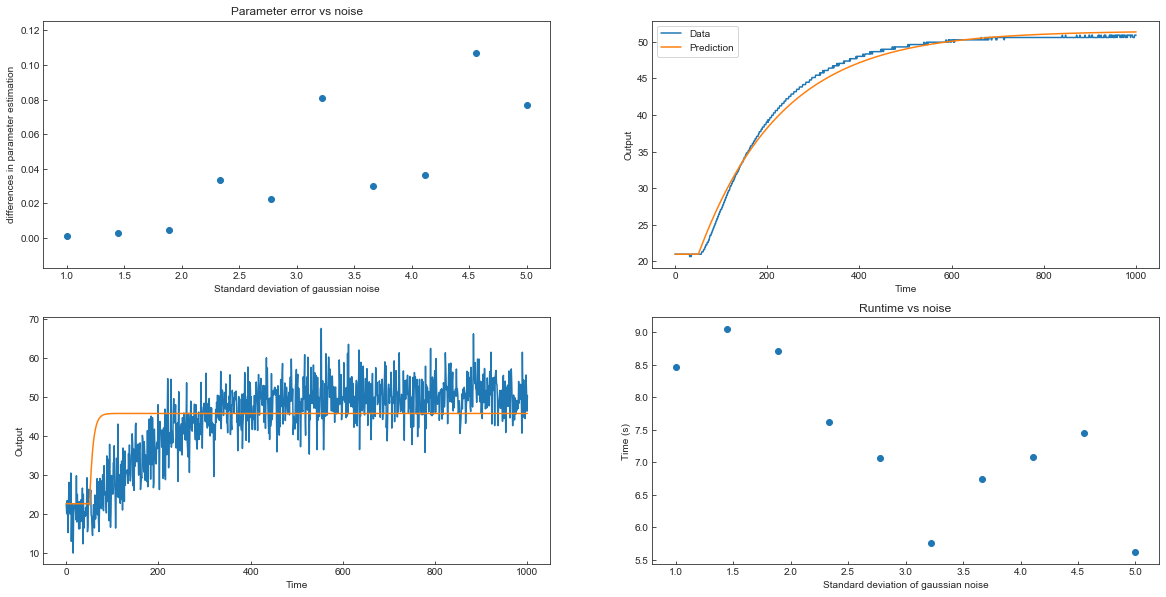

In [45]:
bnds = ((-1,1),(-1,1),(-1,1),(-1,1))
Parameter_error(bnds, 'Step1.csv')

In [29]:
#at s=3 it may not have converged